In [1]:
!python -V

Python 3.9.25


In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [7]:
import mlflow


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2026/02/19 19:08:39 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/19 19:08:39 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/joeyge1218/MLOps-zoomcamp/02-experiment-tracking/mlruns/2', creation_time=1770415770250, experiment_id='2', last_update_time=1770415770250, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [13]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [14]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829628

/tmp/ipykernel_1815/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_1815/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


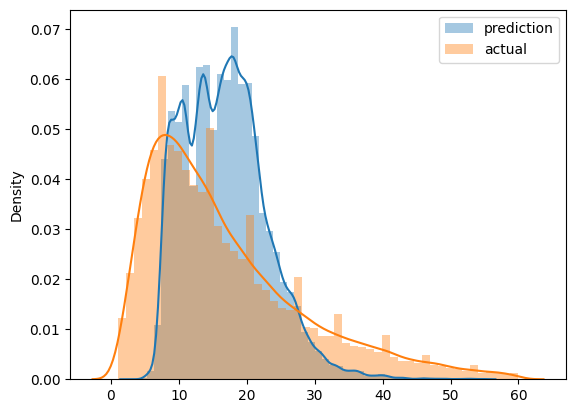

In [14]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [8]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [15]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [17]:
len(df_train), len(df_val)

(73908, 61921)

In [16]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [17]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [18]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715200888857

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [22]:
with mlflow.start_run():

    mlflow.set_tag("developer", "joey")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [9]:
import xgboost as xgb

In [10]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [19]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [11]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [31]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:08:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.16854                           
[1]	validation-rmse:7.75840                           
[2]	validation-rmse:7.15015                           
[3]	validation-rmse:6.88807                           
[4]	validation-rmse:6.76997                           
[5]	validation-rmse:6.70846                           
[6]	validation-rmse:6.67366                           
[7]	validation-rmse:6.65476                           
[8]	validation-rmse:6.64206                           
[9]	validation-rmse:6.63237                           
[10]	validation-rmse:6.62716                          
[11]	validation-rmse:6.62422                          
[12]	validation-rmse:6.62120                          
[13]	validation-rmse:6.61542                          
[14]	validation-rmse:6.61349                          
[15]	validation-rmse:6.61112                          
[16]	validation-rmse:6.60855                          
[17]	validation-rmse:6.60699                          
[18]	valid

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:09:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69598                                                   
[1]	validation-rmse:11.22052                                                   
[2]	validation-rmse:10.78880                                                   
[3]	validation-rmse:10.38950                                                   
[4]	validation-rmse:10.02987                                                   
[5]	validation-rmse:9.69864                                                    
[6]	validation-rmse:9.39862                                                    
[7]	validation-rmse:9.12464                                                    
[8]	validation-rmse:8.87268                                                    
[9]	validation-rmse:8.64858                                                    
[10]	validation-rmse:8.44120                                                   
[11]	validation-rmse:8.26280                                                   
[12]	validation-rmse:8.09107            

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:16:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.32466                                                       
[1]	validation-rmse:7.17951                                                       
[2]	validation-rmse:6.86019                                                       
[3]	validation-rmse:6.74971                                                       
[4]	validation-rmse:6.70888                                                       
[5]	validation-rmse:6.69168                                                       
[6]	validation-rmse:6.67612                                                       
[7]	validation-rmse:6.66729                                                       
[8]	validation-rmse:6.66440                                                       
[9]	validation-rmse:6.66102                                                       
[10]	validation-rmse:6.65573                                                      
[11]	validation-rmse:6.65344                                                      
[12]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:17:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.25368                                                       
[1]	validation-rmse:7.04375                                                       
[2]	validation-rmse:6.69315                                                       
[3]	validation-rmse:6.57812                                                       
[4]	validation-rmse:6.53009                                                       
[5]	validation-rmse:6.51151                                                       
[6]	validation-rmse:6.49698                                                       
[7]	validation-rmse:6.49069                                                       
[8]	validation-rmse:6.48363                                                       
[9]	validation-rmse:6.47217                                                       
[10]	validation-rmse:6.46807                                                      
[11]	validation-rmse:6.46257                                                      
[12]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:18:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.86716                                                       
[2]	validation-rmse:9.08116                                                       
[3]	validation-rmse:8.48515                                                       
[4]	validation-rmse:8.03781                                                       
[5]	validation-rmse:7.70596                                                       
[6]	validation-rmse:7.46161                                                       
[7]	validation-rmse:7.28055                                                       
[8]	validation-rmse:7.14755                                                       
[9]	validation-rmse:7.04840                                                       
[10]	validation-rmse:6.97473                                                      
[11]	validation-rmse:6.91931                                                      
[12]	validation-rmse:6.87725                                                      
[13]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:19:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.22908                                                      
[1]	validation-rmse:7.80286                                                      
[2]	validation-rmse:7.16686                                                      
[3]	validation-rmse:6.88262                                                      
[4]	validation-rmse:6.74290                                                      
[5]	validation-rmse:6.67298                                                      
[6]	validation-rmse:6.63827                                                      
[7]	validation-rmse:6.61643                                                      
[8]	validation-rmse:6.60047                                                      
[9]	validation-rmse:6.59077                                                      
[10]	validation-rmse:6.58323                                                     
[11]	validation-rmse:6.57981                                                     
[12]	validation-

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:20:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.26928                                                     
[1]	validation-rmse:10.47424                                                     
[2]	validation-rmse:9.80709                                                      
[3]	validation-rmse:9.24833                                                      
[4]	validation-rmse:8.78517                                                      
[5]	validation-rmse:8.40472                                                      
[6]	validation-rmse:8.08864                                                      
[7]	validation-rmse:7.83283                                                      
[8]	validation-rmse:7.62234                                                      
[9]	validation-rmse:7.44865                                                      
[10]	validation-rmse:7.31051                                                     
[11]	validation-rmse:7.19429                                                     
[12]	validation-

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:22:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.40946                                                     
[1]	validation-rmse:10.71191                                                     
[2]	validation-rmse:10.10398                                                     
[3]	validation-rmse:9.57992                                                      
[4]	validation-rmse:9.13160                                                      
[5]	validation-rmse:8.74198                                                      
[6]	validation-rmse:8.41050                                                      
[7]	validation-rmse:8.13103                                                      
[8]	validation-rmse:7.88898                                                      
[9]	validation-rmse:7.69383                                                      
[10]	validation-rmse:7.52311                                                     
[11]	validation-rmse:7.38087                                                     
[12]	validation-

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:26:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.06035                                                       
[4]	validation-rmse:8.60373                                                       
[5]	validation-rmse:8.23957                                                       
[6]	validation-rmse:7.95105                                                       
[7]	validation-rmse:7.72261                                                       
[8]	validation-rmse:7.53953                                                       
[9]	validation-rmse:7.39471                                                       
[10]	validation-rmse:7.28065                                                      
[11]	validation-rmse:7.19047                                                      
[12]	validation-rmse:7.11790                                                      
[13]	validation-rmse:7.06023                                                      
[14]	validation-rmse:7.01458                                                      
[15]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:27:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.78628                                                      
[1]	validation-rmse:11.38816                                                      
[2]	validation-rmse:11.01727                                                      
[3]	validation-rmse:10.67267                                                      
[4]	validation-rmse:10.35161                                                      
[5]	validation-rmse:10.05363                                                      
[6]	validation-rmse:9.77692                                                       
[7]	validation-rmse:9.52068                                                       
[8]	validation-rmse:9.28389                                                       
[9]	validation-rmse:9.06441                                                       
[10]	validation-rmse:8.86214                                                      
[11]	validation-rmse:8.67522                                                      
[12]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:30:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.93208                                                        
[1]	validation-rmse:8.54763                                                        
[2]	validation-rmse:7.71924                                                        
[3]	validation-rmse:7.24608                                                        
[4]	validation-rmse:6.97014                                                        
[5]	validation-rmse:6.81975                                                        
[6]	validation-rmse:6.72092                                                        
[7]	validation-rmse:6.66061                                                        
[8]	validation-rmse:6.61429                                                        
[9]	validation-rmse:6.59119                                                        
[10]	validation-rmse:6.57202                                                       
[11]	validation-rmse:6.55970                                                

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:32:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.57703                                                        
[1]	validation-rmse:6.73013                                                        
[2]	validation-rmse:6.55515                                                        
[3]	validation-rmse:6.50805                                                        
[4]	validation-rmse:6.48947                                                        
[5]	validation-rmse:6.48349                                                        
[6]	validation-rmse:6.47784                                                        
[7]	validation-rmse:6.46694                                                        
[8]	validation-rmse:6.45773                                                        
[9]	validation-rmse:6.45115                                                        
[10]	validation-rmse:6.44893                                                       
[11]	validation-rmse:6.44338                                                

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:32:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69781                                                      
[1]	validation-rmse:11.22461                                                      
[2]	validation-rmse:10.79162                                                      
[3]	validation-rmse:10.39597                                                      
[4]	validation-rmse:10.03531                                                      
[5]	validation-rmse:9.70510                                                       
[6]	validation-rmse:9.40559                                                       
[7]	validation-rmse:9.13281                                                       
[8]	validation-rmse:8.88496                                                       
[9]	validation-rmse:8.65963                                                       
[10]	validation-rmse:8.45646                                                      
[11]	validation-rmse:8.27154                                                      
[12]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:34:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.54646                                                       
[1]	validation-rmse:10.95236                                                       
[2]	validation-rmse:10.42271                                                       
[3]	validation-rmse:9.95440                                                        
[4]	validation-rmse:9.54015                                                        
[5]	validation-rmse:9.17612                                                        
[6]	validation-rmse:8.85288                                                        
[7]	validation-rmse:8.57036                                                        
[8]	validation-rmse:8.32342                                                        
[9]	validation-rmse:8.10670                                                        
[10]	validation-rmse:7.91577                                                       
[11]	validation-rmse:7.75033                                                

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:37:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.12739                                                       
[1]	validation-rmse:10.23781                                                       
[2]	validation-rmse:9.51400                                                        
[3]	validation-rmse:8.93130                                                        
[4]	validation-rmse:8.46535                                                        
[5]	validation-rmse:8.09468                                                        
[6]	validation-rmse:7.80149                                                        
[7]	validation-rmse:7.57019                                                        
[8]	validation-rmse:7.38832                                                        
[9]	validation-rmse:7.24582                                                        
[10]	validation-rmse:7.13370                                                       
[11]	validation-rmse:7.04546                                                

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:39:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77902                                                       
[1]	validation-rmse:11.37561                                                       
[2]	validation-rmse:11.00129                                                       
[3]	validation-rmse:10.65434                                                       
[4]	validation-rmse:10.33332                                                       
[5]	validation-rmse:10.03621                                                       
[6]	validation-rmse:9.76189                                                        
[7]	validation-rmse:9.50866                                                        
[8]	validation-rmse:9.27530                                                        
[9]	validation-rmse:9.06059                                                        
[10]	validation-rmse:8.86318                                                       
[11]	validation-rmse:8.68175                                                

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:41:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.68018                                                       
[1]	validation-rmse:11.19236                                                       
[2]	validation-rmse:10.74645                                                       
[3]	validation-rmse:10.33998                                                       
[4]	validation-rmse:9.96977                                                        
[5]	validation-rmse:9.63361                                                        
[6]	validation-rmse:9.32813                                                        
[7]	validation-rmse:9.05133                                                        
[8]	validation-rmse:8.80075                                                        
[9]	validation-rmse:8.57426                                                        
[10]	validation-rmse:8.36951                                                       
[11]	validation-rmse:8.18550                                                

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:43:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.61690                                                       
[1]	validation-rmse:9.44726                                                        
[2]	validation-rmse:8.60442                                                        
[3]	validation-rmse:8.00727                                                        
[4]	validation-rmse:7.59213                                                        
[5]	validation-rmse:7.30521                                                        
[6]	validation-rmse:7.10289                                                        
[7]	validation-rmse:6.96224                                                        
[8]	validation-rmse:6.85938                                                        
[9]	validation-rmse:6.78933                                                        
[10]	validation-rmse:6.73593                                                       
[11]	validation-rmse:6.69930                                                

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:45:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.81628                                                        
[1]	validation-rmse:6.65062                                                        
[2]	validation-rmse:6.61586                                                        
[3]	validation-rmse:6.60072                                                        
[4]	validation-rmse:6.59335                                                        
[5]	validation-rmse:6.58530                                                        
[6]	validation-rmse:6.58286                                                        
[7]	validation-rmse:6.57810                                                        
[8]	validation-rmse:6.57566                                                        
[9]	validation-rmse:6.57430                                                        
[10]	validation-rmse:6.56979                                                       
[11]	validation-rmse:6.56780                                                

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:46:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.71165                                                    
[1]	validation-rmse:11.25161                                                    
[2]	validation-rmse:10.82941                                                    
[3]	validation-rmse:10.44321                                                    
[4]	validation-rmse:10.09044                                                    
[5]	validation-rmse:9.76846                                                     
[6]	validation-rmse:9.47488                                                     
[7]	validation-rmse:9.20860                                                     
[8]	validation-rmse:8.96584                                                     
[9]	validation-rmse:8.74571                                                     
[10]	validation-rmse:8.54702                                                    
[11]	validation-rmse:8.36618                                                    
[12]	validation-rmse:8.20284

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:47:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.73988                                                     
[1]	validation-rmse:6.57748                                                     
[2]	validation-rmse:6.57543                                                     
[3]	validation-rmse:6.56411                                                     
[4]	validation-rmse:6.55441                                                     
[5]	validation-rmse:6.54543                                                     
[6]	validation-rmse:6.53339                                                     
[7]	validation-rmse:6.52445                                                     
[8]	validation-rmse:6.51518                                                     
[9]	validation-rmse:6.51262                                                     
[10]	validation-rmse:6.51341                                                    
[11]	validation-rmse:6.50972                                                    
[12]	validation-rmse:6.50509

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:48:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.02738                                                    
[1]	validation-rmse:8.63250                                                     
[2]	validation-rmse:7.77514                                                     
[3]	validation-rmse:7.25878                                                     
[4]	validation-rmse:6.95244                                                     
[5]	validation-rmse:6.76933                                                     
[6]	validation-rmse:6.66050                                                     
[7]	validation-rmse:6.58882                                                     
[8]	validation-rmse:6.53775                                                     
[9]	validation-rmse:6.50673                                                     
[10]	validation-rmse:6.48565                                                    
[11]	validation-rmse:6.46895                                                    
[12]	validation-rmse:6.45759

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:49:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.38274                                                    
[1]	validation-rmse:9.09833                                                     
[2]	validation-rmse:8.22171                                                     
[3]	validation-rmse:7.63496                                                     
[4]	validation-rmse:7.24824                                                     
[5]	validation-rmse:6.99032                                                     
[6]	validation-rmse:6.82609                                                     
[7]	validation-rmse:6.71427                                                     
[8]	validation-rmse:6.63594                                                     
[9]	validation-rmse:6.58387                                                     
[10]	validation-rmse:6.54356                                                    
[11]	validation-rmse:6.51525                                                    
[12]	validation-rmse:6.49533

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:50:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.90577                                                     
[1]	validation-rmse:8.48394                                                     
[2]	validation-rmse:7.63874                                                     
[3]	validation-rmse:7.15407                                                     
[4]	validation-rmse:6.87647                                                     
[5]	validation-rmse:6.71035                                                     
[6]	validation-rmse:6.61451                                                     
[7]	validation-rmse:6.55315                                                     
[8]	validation-rmse:6.51265                                                     
[9]	validation-rmse:6.48752                                                     
[10]	validation-rmse:6.46818                                                    
[11]	validation-rmse:6.45427                                                    
[12]	validation-rmse:6.44379

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:51:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.25814                                                    
[1]	validation-rmse:8.93105                                                     
[2]	validation-rmse:8.05619                                                     
[3]	validation-rmse:7.48924                                                     
[4]	validation-rmse:7.13089                                                     
[5]	validation-rmse:6.90256                                                     
[6]	validation-rmse:6.75353                                                     
[7]	validation-rmse:6.65797                                                     
[8]	validation-rmse:6.59415                                                     
[9]	validation-rmse:6.55025                                                     
[10]	validation-rmse:6.51816                                                    
[11]	validation-rmse:6.49822                                                    
[12]	validation-rmse:6.48062

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:53:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.94853                                                     
[1]	validation-rmse:8.54450                                                     
[2]	validation-rmse:7.70590                                                     
[3]	validation-rmse:7.21683                                                     
[4]	validation-rmse:6.93696                                                     
[5]	validation-rmse:6.77148                                                     
[6]	validation-rmse:6.67199                                                     
[7]	validation-rmse:6.61295                                                     
[8]	validation-rmse:6.56754                                                     
[9]	validation-rmse:6.53688                                                     
[10]	validation-rmse:6.51893                                                    
[11]	validation-rmse:6.50314                                                    
[12]	validation-rmse:6.49059

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:54:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.26350                                                     
[1]	validation-rmse:7.79471                                                     
[2]	validation-rmse:7.11382                                                     
[3]	validation-rmse:6.80141                                                     
[4]	validation-rmse:6.64909                                                     
[5]	validation-rmse:6.57064                                                     
[6]	validation-rmse:6.52502                                                     
[7]	validation-rmse:6.50216                                                     
[8]	validation-rmse:6.48397                                                     
[9]	validation-rmse:6.47071                                                     
[10]	validation-rmse:6.46283                                                    
[11]	validation-rmse:6.45691                                                    
[12]	validation-rmse:6.45213

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:55:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.58808                                                    
[1]	validation-rmse:9.39232                                                     
[2]	validation-rmse:8.52923                                                     
[3]	validation-rmse:7.91570                                                     
[4]	validation-rmse:7.48544                                                     
[5]	validation-rmse:7.18569                                                     
[6]	validation-rmse:6.97723                                                     
[7]	validation-rmse:6.83029                                                     
[8]	validation-rmse:6.73061                                                     
[9]	validation-rmse:6.65482                                                     
[10]	validation-rmse:6.60264                                                    
[11]	validation-rmse:6.56300                                                    
[12]	validation-rmse:6.53334

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:56:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.71223                                                   
[1]	validation-rmse:9.57454                                                    
[2]	validation-rmse:8.72498                                                    
[3]	validation-rmse:8.10059                                                    
[4]	validation-rmse:7.64418                                                    
[5]	validation-rmse:7.31724                                                    
[6]	validation-rmse:7.07931                                                    
[7]	validation-rmse:6.91009                                                    
[8]	validation-rmse:6.78752                                                    
[9]	validation-rmse:6.70099                                                    
[10]	validation-rmse:6.63570                                                   
[11]	validation-rmse:6.58871                                                   
[12]	validation-rmse:6.55138            

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:58:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.97230                                                   
[1]	validation-rmse:9.98620                                                    
[2]	validation-rmse:9.21059                                                    
[3]	validation-rmse:8.59834                                                    
[4]	validation-rmse:8.12651                                                    
[5]	validation-rmse:7.76515                                                    
[6]	validation-rmse:7.48305                                                    
[7]	validation-rmse:7.27408                                                    
[8]	validation-rmse:7.10942                                                    
[9]	validation-rmse:6.99205                                                    
[10]	validation-rmse:6.89591                                                   
[11]	validation-rmse:6.82281                                                   
[12]	validation-rmse:6.76353            

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:01:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.30938                                                    
[1]	validation-rmse:9.02269                                                     
[2]	validation-rmse:8.17199                                                     
[3]	validation-rmse:7.61803                                                     
[4]	validation-rmse:7.26188                                                     
[5]	validation-rmse:7.02309                                                     
[6]	validation-rmse:6.87483                                                     
[7]	validation-rmse:6.78110                                                     
[8]	validation-rmse:6.71713                                                     
[9]	validation-rmse:6.66293                                                     
[10]	validation-rmse:6.62888                                                    
[11]	validation-rmse:6.59810                                                    
[12]	validation-rmse:6.58177

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:02:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.42090                                                     
[1]	validation-rmse:7.95018                                                     
[2]	validation-rmse:7.22636                                                     
[3]	validation-rmse:6.87495                                                     
[4]	validation-rmse:6.70127                                                     
[5]	validation-rmse:6.60593                                                     
[6]	validation-rmse:6.55447                                                     
[7]	validation-rmse:6.52422                                                     
[8]	validation-rmse:6.50430                                                     
[9]	validation-rmse:6.48874                                                     
[10]	validation-rmse:6.47531                                                    
[11]	validation-rmse:6.46770                                                    
[12]	validation-rmse:6.46436

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:03:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.34538                                                    
[1]	validation-rmse:7.09887                                                    
[2]	validation-rmse:6.72339                                                    
[3]	validation-rmse:6.58964                                                    
[4]	validation-rmse:6.52961                                                    
[5]	validation-rmse:6.50541                                                    
[6]	validation-rmse:6.48204                                                    
[7]	validation-rmse:6.46956                                                    
[8]	validation-rmse:6.46275                                                    
[9]	validation-rmse:6.45931                                                    
[10]	validation-rmse:6.45495                                                   
[11]	validation-rmse:6.44986                                                   
[12]	validation-rmse:6.44440            

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:04:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.47388                                                   
[1]	validation-rmse:10.82252                                                   
[2]	validation-rmse:10.25374                                                   
[3]	validation-rmse:9.75081                                                    
[4]	validation-rmse:9.31472                                                    
[5]	validation-rmse:8.93555                                                    
[6]	validation-rmse:8.60303                                                    
[7]	validation-rmse:8.31900                                                    
[8]	validation-rmse:8.07674                                                    
[9]	validation-rmse:7.86450                                                    
[10]	validation-rmse:7.68222                                                   
[11]	validation-rmse:7.52204                                                   
[12]	validation-rmse:7.39352            

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:08:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.54528                                                     
[1]	validation-rmse:7.22240                                                     
[2]	validation-rmse:6.77341                                                     
[3]	validation-rmse:6.60892                                                     
[4]	validation-rmse:6.54003                                                     
[5]	validation-rmse:6.50589                                                     
[6]	validation-rmse:6.49111                                                     
[7]	validation-rmse:6.48765                                                     
[8]	validation-rmse:6.47668                                                     
[9]	validation-rmse:6.47414                                                     
[10]	validation-rmse:6.46885                                                    
[11]	validation-rmse:6.46347                                                    
[12]	validation-rmse:6.45875

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:09:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.23940                                                       
[1]	validation-rmse:6.75853                                                       
[2]	validation-rmse:6.68358                                                       
[3]	validation-rmse:6.65955                                                       
[4]	validation-rmse:6.64093                                                       
[5]	validation-rmse:6.63510                                                       
[6]	validation-rmse:6.63254                                                       
[7]	validation-rmse:6.62263                                                       
[8]	validation-rmse:6.61824                                                       
[9]	validation-rmse:6.61598                                                       
[10]	validation-rmse:6.61264                                                      
[11]	validation-rmse:6.61057                                                      
[12]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:09:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.59926                                                      
[1]	validation-rmse:8.17539                                                      
[2]	validation-rmse:7.42997                                                      
[3]	validation-rmse:7.05297                                                      
[4]	validation-rmse:6.84469                                                      
[5]	validation-rmse:6.73843                                                      
[6]	validation-rmse:6.67211                                                      
[7]	validation-rmse:6.62849                                                      
[8]	validation-rmse:6.60287                                                      
[9]	validation-rmse:6.58634                                                      
[10]	validation-rmse:6.57722                                                     
[11]	validation-rmse:6.57129                                                     
[12]	validation-

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:10:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.79972                                                      
[1]	validation-rmse:7.39667                                                      
[2]	validation-rmse:6.86333                                                      
[3]	validation-rmse:6.65450                                                      
[4]	validation-rmse:6.55820                                                      
[5]	validation-rmse:6.51279                                                      
[6]	validation-rmse:6.48762                                                      
[7]	validation-rmse:6.47348                                                      
[8]	validation-rmse:6.45953                                                      
[9]	validation-rmse:6.45347                                                      
[10]	validation-rmse:6.44737                                                     
[11]	validation-rmse:6.44297                                                     
[12]	validation-

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:11:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.86814                                                      
[1]	validation-rmse:6.91734                                                      
[2]	validation-rmse:6.70252                                                      
[3]	validation-rmse:6.64045                                                      
[4]	validation-rmse:6.61455                                                      
[5]	validation-rmse:6.60299                                                      
[6]	validation-rmse:6.59898                                                      
[7]	validation-rmse:6.59511                                                      
[8]	validation-rmse:6.58793                                                      
[9]	validation-rmse:6.58444                                                      
[10]	validation-rmse:6.57798                                                     
[11]	validation-rmse:6.57603                                                     
[12]	validation-

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:12:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.22844                                                     
[1]	validation-rmse:10.40182                                                     
[2]	validation-rmse:9.71159                                                      
[3]	validation-rmse:9.13989                                                      
[4]	validation-rmse:8.66832                                                      
[5]	validation-rmse:8.28220                                                      
[6]	validation-rmse:7.96641                                                      
[7]	validation-rmse:7.71049                                                      
[8]	validation-rmse:7.50285                                                      
[9]	validation-rmse:7.33379                                                      
[10]	validation-rmse:7.19689                                                     
[11]	validation-rmse:7.08607                                                     
[12]	validation-

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:15:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.98522                                                     
[1]	validation-rmse:10.00872                                                     
[2]	validation-rmse:9.23309                                                      
[3]	validation-rmse:8.63271                                                      
[4]	validation-rmse:8.16163                                                      
[5]	validation-rmse:7.80493                                                      
[6]	validation-rmse:7.51900                                                      
[7]	validation-rmse:7.31009                                                      
[8]	validation-rmse:7.14786                                                      
[9]	validation-rmse:7.02390                                                      
[10]	validation-rmse:6.92542                                                     
[11]	validation-rmse:6.85055                                                     
[12]	validation-

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:17:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.68768                                                      
[1]	validation-rmse:9.54362                                                       
[2]	validation-rmse:8.69681                                                       
[3]	validation-rmse:8.08435                                                       
[4]	validation-rmse:7.64756                                                       
[5]	validation-rmse:7.32924                                                       
[6]	validation-rmse:7.10394                                                       
[7]	validation-rmse:6.94231                                                       
[8]	validation-rmse:6.82824                                                       
[9]	validation-rmse:6.74433                                                       
[10]	validation-rmse:6.68296                                                      
[11]	validation-rmse:6.63655                                                      
[12]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:19:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.37219                                                      
[1]	validation-rmse:10.64802                                                      
[2]	validation-rmse:10.02619                                                      
[3]	validation-rmse:9.49521                                                       
[4]	validation-rmse:9.04310                                                       
[5]	validation-rmse:8.66024                                                       
[6]	validation-rmse:8.33661                                                       
[7]	validation-rmse:8.06632                                                       
[8]	validation-rmse:7.83637                                                       
[9]	validation-rmse:7.64519                                                       
[10]	validation-rmse:7.48518                                                      
[11]	validation-rmse:7.35097                                                      
[12]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:21:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.67737                                                      
[1]	validation-rmse:9.52877                                                       
[2]	validation-rmse:8.68216                                                       
[3]	validation-rmse:8.06863                                                       
[4]	validation-rmse:7.63102                                                       
[5]	validation-rmse:7.31872                                                       
[6]	validation-rmse:7.09803                                                       
[7]	validation-rmse:6.94131                                                       
[8]	validation-rmse:6.82741                                                       
[9]	validation-rmse:6.74639                                                       
[10]	validation-rmse:6.68680                                                      
[11]	validation-rmse:6.64183                                                      
[12]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:22:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.84798                                                      
[1]	validation-rmse:9.79457                                                       
[2]	validation-rmse:8.98912                                                       
[3]	validation-rmse:8.38372                                                       
[4]	validation-rmse:7.93360                                                       
[5]	validation-rmse:7.59813                                                       
[6]	validation-rmse:7.35392                                                       
[7]	validation-rmse:7.17234                                                       
[8]	validation-rmse:7.03390                                                       
[9]	validation-rmse:6.93443                                                       
[10]	validation-rmse:6.86012                                                      
[11]	validation-rmse:6.79966                                                      
[12]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:24:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.60011                                                      
[1]	validation-rmse:11.04953                                                      
[2]	validation-rmse:10.55256                                                      
[3]	validation-rmse:10.10754                                                      
[4]	validation-rmse:9.70912                                                       
[5]	validation-rmse:9.35504                                                       
[6]	validation-rmse:9.03541                                                       
[7]	validation-rmse:8.75584                                                       
[8]	validation-rmse:8.50595                                                       
[9]	validation-rmse:8.28219                                                       
[10]	validation-rmse:8.08894                                                      
[11]	validation-rmse:7.91358                                                      
[12]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:28:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.30265                                                      
[1]	validation-rmse:10.52440                                                      
[2]	validation-rmse:9.86299                                                       
[3]	validation-rmse:9.30306                                                       
[4]	validation-rmse:8.83048                                                       
[5]	validation-rmse:8.43539                                                       
[6]	validation-rmse:8.10626                                                       
[7]	validation-rmse:7.83236                                                       
[8]	validation-rmse:7.60639                                                       
[9]	validation-rmse:7.41774                                                       
[10]	validation-rmse:7.26277                                                      
[11]	validation-rmse:7.13471                                                      
[12]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:31:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.18233                                                      
[1]	validation-rmse:10.32361                                                      
[2]	validation-rmse:9.61249                                                       
[3]	validation-rmse:9.03037                                                       
[4]	validation-rmse:8.55288                                                       
[5]	validation-rmse:8.16782                                                       
[6]	validation-rmse:7.85404                                                       
[7]	validation-rmse:7.60142                                                       
[8]	validation-rmse:7.39885                                                       
[9]	validation-rmse:7.23643                                                       
[10]	validation-rmse:7.10595                                                      
[11]	validation-rmse:7.00100                                                      
[12]

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:33:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.14846                                                       
[1]	validation-rmse:10.27410                                                       
[2]	validation-rmse:9.55872                                                        
[3]	validation-rmse:8.97839                                                        
[4]	validation-rmse:8.51279                                                        
[5]	validation-rmse:8.13842                                                        
[6]	validation-rmse:7.84240                                                        
[7]	validation-rmse:7.60419                                                        
[8]	validation-rmse:7.41754                                                        
[9]	validation-rmse:7.26792                                                        
[10]	validation-rmse:7.15067                                                       
[11]	validation-rmse:7.05555                                                

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:35:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.55835                                                       
[1]	validation-rmse:10.97274                                                       
[2]	validation-rmse:10.44981                                                       
[3]	validation-rmse:9.98458                                                        
[4]	validation-rmse:9.57200                                                        
[5]	validation-rmse:9.20626                                                        
[6]	validation-rmse:8.88332                                                        
[7]	validation-rmse:8.59802                                                        
[8]	validation-rmse:8.34710                                                        
[9]	validation-rmse:8.12657                                                        
[10]	validation-rmse:7.93404                                                       
[11]	validation-rmse:7.76578                                                

In [22]:
params = {
    'learning_rate': 0.12901354637265633,
    'max_depth': 35,
    'min_child_weight': 1.1431563325678897,
    'objective': 'reg:squarederror',
    'reg_alpha': 0.01166167727005191,
    'reg_lambda': 0.015752858336326257,
    'seed': 42
}

# with mlflow.start_run():
#     mlflow.set_tag()
#     mlflow.log_param
mlflow.xgboost.autolog()
booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)


2026/02/19 20:16:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '13519395f8374c0ea049db0c052a82ad', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:11.18233
[1]	validation-rmse:10.32361
[2]	validation-rmse:9.61249
[3]	validation-rmse:9.03037
[4]	validation-rmse:8.55288
[5]	validation-rmse:8.16782
[6]	validation-rmse:7.85404
[7]	validation-rmse:7.60142
[8]	validation-rmse:7.39885
[9]	validation-rmse:7.23643
[10]	validation-rmse:7.10595
[11]	validation-rmse:7.00100
[12]	validation-rmse:6.91537
[13]	validation-rmse:6.84545
[14]	validation-rmse:6.78895
[15]	validation-rmse:6.74252
[16]	validation-rmse:6.70623
[17]	validation-rmse:6.67351
[18]	validation-rmse:6.64648
[19]	validation-rmse:6.62367
[20]	validation-rmse:6.60467
[21]	validation-rmse:6.58959
[22]	validation-rmse:6.57573
[23]	validation-rmse:6.56441
[24]	validation-rmse:6.55409
[25]	validation-rmse:6.54599
[26]	validation-rmse:6.53860
[27]	validation-rmse:6.53109
[28]	validation-rmse:6.52480
[29]	validation-rmse:6.51929
[30]	validation-rmse:6.51493
[31]	validation-rmse:6.51115
[32]	validation-rmse:6.50798
[33]	validation-rmse:6.50568
[34]	validation-rmse:6

2026/02/19 20:19:42 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/02/19 20:19:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/19 20:19:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:19:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2026/02/19 20:19:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
with mlflow.start_run():
    best_params = {
        'learning_rate': 0.12901354637265633,
        'max_depth': 35,
        'min_child_weight': 1.1431563325678897,
        'objective': 'reg:squarederror',
        'reg_alpha': 0.01166167727005191,
        'reg_lambda': 0.015752858336326257,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:17:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.18233
[1]	validation-rmse:10.32361
[2]	validation-rmse:9.61249
[3]	validation-rmse:9.03037
[4]	validation-rmse:8.55288
[5]	validation-rmse:8.16782
[6]	validation-rmse:7.85404
[7]	validation-rmse:7.60142
[8]	validation-rmse:7.39885
[9]	validation-rmse:7.23643
[10]	validation-rmse:7.10595
[11]	validation-rmse:7.00100
[12]	validation-rmse:6.91537
[13]	validation-rmse:6.84545
[14]	validation-rmse:6.78895
[15]	validation-rmse:6.74252
[16]	validation-rmse:6.70623
[17]	validation-rmse:6.67351
[18]	validation-rmse:6.64648
[19]	validation-rmse:6.62367
[20]	validation-rmse:6.60467
[21]	validation-rmse:6.58959
[22]	validation-rmse:6.57573
[23]	validation-rmse:6.56441
[24]	validation-rmse:6.55409
[25]	validation-rmse:6.54599
[26]	validation-rmse:6.53860
[27]	validation-rmse:6.53109
[28]	validation-rmse:6.52480
[29]	validation-rmse:6.51929
[30]	validation-rmse:6.51493
[31]	validation-rmse:6.51115
[32]	validation-rmse:6.50798
[33]	validation-rmse:6.50568
[34]	validation-rmse:6

2026/02/19 19:20:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/joeyge1218/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:20:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2026/02/19 19:20:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
